In [199]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Add, Activation
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, f1_score, classification_report, r2_score
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [200]:
# Definitions
img_width, img_height= 128, 128
batch_size = 32
No_epochs= 200

In [201]:
train_labels = {"ID": [], "class": [], "x_cent": [], "y_cent": [], "width": [], "height": [], "path": []}
test_labels = {"ID": [], "class": [], "x_cent": [], "y_cent": [], "width": [], "height": [], "path": []}

data_paths= ["Data/axial_t1wce_2_class/", "Data/coronal_t1wce_2_class/", "Data/sagittal_t1wce_2_class/"]

In [202]:
for data_path in data_paths:
    train_labels_path = os.path.join(data_path, "labels/train")
    test_labels_path = os.path.join(data_path, "labels/test")

    train_labels_filenames = os.listdir(train_labels_path)
    test_labels_filenames = os.listdir(test_labels_path)
    
    # Train labels
    for label_filename in train_labels_filenames:
        file_path = os.path.join(train_labels_path, label_filename)
        with open(file_path, "r") as train_label_file:
            content = train_label_file.read()
            parts= content.split()
            train_labels["ID"].append(label_filename[:-4])
            train_labels["class"].append(int(parts[0]))
            train_labels["x_cent"].append(float(parts[1]))
            train_labels["y_cent"].append(float(parts[2]))
            train_labels["width"].append(float(parts[3]))
            train_labels["height"].append(float(parts[4]))
            train_labels["path"].append(data_path + 'images/train/' + label_filename[:-4] + '.jpg')
    train_labels_df = pd.DataFrame(train_labels)
    
    # Test labels 
    for label_filename in test_labels_filenames:
        file_path = os.path.join(test_labels_path, label_filename)
        with open(file_path, "r") as test_label_file:
            content = test_label_file.read()
            parts= content.split()
            test_labels["ID"].append(label_filename[:-4])
            test_labels["class"].append(int(parts[0]))
            test_labels["x_cent"].append(float(parts[1]))
            test_labels["y_cent"].append(float(parts[2]))
            test_labels["width"].append(float(parts[3]))
            test_labels["height"].append(float(parts[4]))
            test_labels["path"].append(data_path + 'images/test/' + label_filename[:-4] + '.jpg')
    test_labels_df = pd.DataFrame(test_labels)

In [203]:
train_labels_df.head()

,ID,class,x_cent,y_cent,width,height,path
0,00095_170,0,0.428991,0.361502,0.144366,0.150235,Data/axial_t1wce_2_class/images/train/00095_17...
1,00095_176,0,0.443075,0.373826,0.142019,0.193662,Data/axial_t1wce_2_class/images/train/00095_17...
2,00095_188,0,0.424883,0.376761,0.215962,0.248826,Data/axial_t1wce_2_class/images/train/00095_18...
3,00095_200,0,0.426643,0.383216,0.250000,0.259390,Data/axial_t1wce_2_class/images/train/00095_20...
4,00095_212,0,0.437793,0.387324,0.237089,0.241784,Data/axial_t1wce_2_class/images/train/00095_21...


In [204]:
# Split the data into training and test sets
train_labels_df, dev_labels_df = train_test_split(train_labels_df, test_size=0.1, random_state=42)

In [205]:
Adding_part= test_labels_df.iloc[0:135]
test_labels_df= test_labels_df.iloc[135:]
train_labels_df= pd.concat([train_labels_df, Adding_part], axis= 0).reset_index()

print('Size of Train set: ', train_labels_df.shape)
print('Size of Dev set: ', dev_labels_df.shape)
print('Size of Test set: ', test_labels_df.shape)

Size of Train set:  (925, 8)
Size of Dev set:  (88, 7)
Size of Test set:  (88, 7)


In [206]:
# Checking data distribution
from collections import Counter
Counter(list(train_labels_df["class"]))

Counter({0: 474, 1: 451})

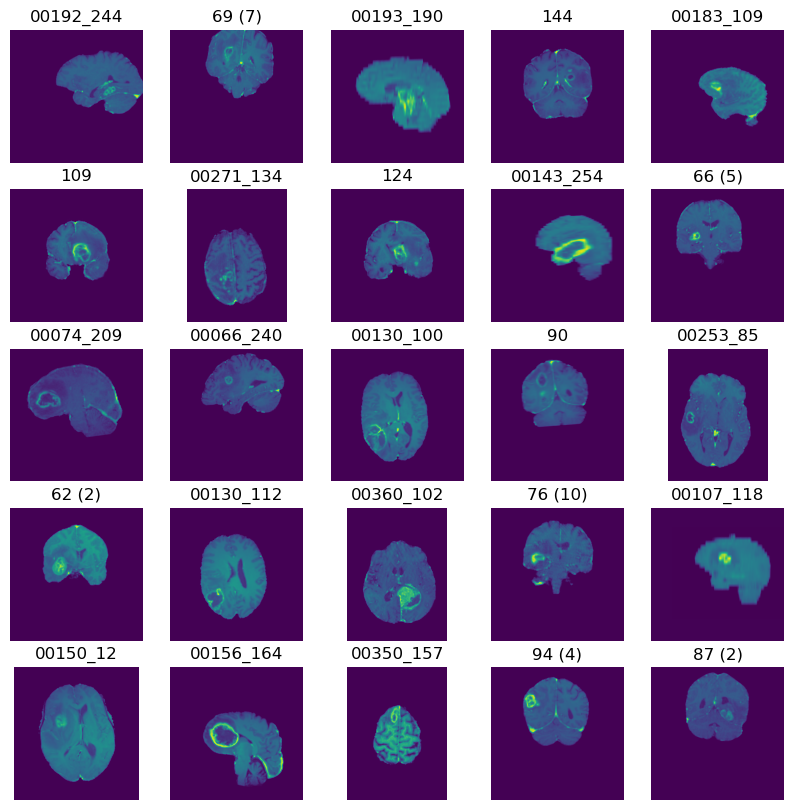

In [207]:
# Plot the images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    #path= data_path + 'images/train/' + train_labels_df['ID'].iloc[i] + '.jpg'
    image= Image.open(train_labels_df['path'].iloc[i])
    plt.imshow(image)
    plt.title(f"{train_labels_df['ID'].iloc[i]}")
    plt.axis('off')
plt.show()

In [208]:
# Function to load and preprocess images
def load_images(X, img_width, img_height):
    images = []
    for image_path in X:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))  # Resize to 128x128
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        #image = image / 255.0  # Normalize pixel values
        images.append(image)

    images = np.array(images)
    return images

# Load and preprocess images
X_train= load_images(train_labels_df['path'], img_width, img_height)

X_test = load_images(test_labels_df['path'], img_width, img_height)

X_dev = load_images(dev_labels_df['path'], img_width, img_height)

In [209]:
def show_image(X, labels=None, figsize=(4, 4), img_width= img_width, img_height= img_height):
    plt.figure(figsize=figsize)
    plt.imshow(X)
    if labels is not None:
        cx, cy, w, h = labels['x_cent'], labels['y_cent'], labels['width'], labels['height']
        cx, cy, w, h = cx*img_width, cy*img_height, w*img_width, h*img_height
        x = cx - w / 2
        y = cy - h / 2
        box = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(box)
        plt.text(x, y-2, f'Class: {labels["class"]}', color='y')

    plt.show()

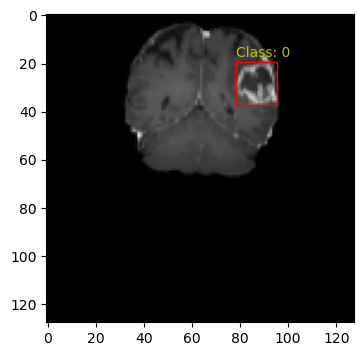

In [210]:
show_image(X= X_dev[80], labels=dev_labels_df.iloc[80])

In [211]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
    # Set device for TensorFlow operations
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
else:
    print('GPU is not available')

GPU is not available


In [213]:
# Define augmentation sequence
seq = iaa.Sequential([
    #iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    #iaa.Affine(rotate=(-10, 10))  # rotate images by -10 to 10 degrees
])

In [214]:

# Function to apply augmentation to images and bounding boxes
def augment_images(images, bboxes):
    augmented_images = []
    augmented_bboxes = []
    for image, bbox in zip(images, bboxes):
        # Convert bounding box to imgaug format
        bbox_imgaug = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[0]+bbox[2], y2=bbox[1]+bbox[3])
        bbs = BoundingBoxesOnImage([bbox_imgaug], shape=image.shape)
        
        # Apply augmentation
        image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
        
        # Convert bounding box back to [x, y, w, h] format
        bbox_aug = [bbs_aug[0].x1, bbs_aug[0].y1, bbs_aug[0].x2 - bbs_aug[0].x1, bbs_aug[0].y2 - bbs_aug[0].y1]
        
        augmented_images.append(image_aug)
        augmented_bboxes.append(bbox_aug)
    
    return np.array(augmented_images), np.array(augmented_bboxes)


In [215]:
# Example usage
X_train_augmented, train_bboxes_augmented = augment_images(X_train, 
                                                           train_labels_df[['x_cent', 'y_cent', 'width', 'height']].values*img_width)
train_bboxes_augmented= train_bboxes_augmented/img_width

In [216]:
# Input layer
image_input = Input(shape=(img_width, img_height, 3))

# First convolutional block
x1= Conv2D(16, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(image_input)
x1= BatchNormalization()(x1)
x1= Activation('relu')(x1)
x1= MaxPooling2D((2, 2))(x1)

# Second convolutional block
x2= Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x1)
x2= BatchNormalization()(x2)
x2= Activation('relu')(x2)

x3= Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x2)
x3= BatchNormalization()(x3)
x3= Activation('relu')(x3)

# skip connection
x3= Add()([x2, x3])
x3= MaxPooling2D((2, 2))(x3)

# Third convolutional block
x4= Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x3)
x4= BatchNormalization()(x4)
x4= Activation('relu')(x4)

x5= Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x4)
x5= BatchNormalization()(x5)
x5= Activation('relu')(x5)

# skip connection
x5= Add()([x4, x5])
x5= MaxPooling2D((2, 2))(x5)

# Fourth convolutional block
x6= Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.002))(x5)
x6= BatchNormalization()(x6)
x6= Activation('relu')(x6)
x6= MaxPooling2D((2, 2))(x6)

# Flatten and dense layers
x7= Flatten()(x6)

x8= Dense(256, activation='relu')(x7)
x8= Dropout(0.2)(x8)

# Output layers for class prediction (sigmoid for binary classification) and bounding box regression
class_output = Dense(1, activation='sigmoid', name='class_output')(x8)

bbox_output = Dense(4, name='bbox_output')(x8)  # 4 values for bounding box (x, y, w, h)

model = tf.keras.Model(inputs=image_input, outputs=[class_output, bbox_output])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 128, 128, 16)         448       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_42 (Ba  (None, 128, 128, 16)         64        ['conv2d_42[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_42 (Activation)  (None, 128, 128, 16)         0         ['batch_normalization_42

Non-trainable params: 672 (2.62 KB)
__________________________________________________________________________________________________


In [217]:
# Compile the model
model.compile(optimizer='adam', loss={'class_output': 'binary_crossentropy', 'bbox_output': 'mean_squared_error'}, 
             metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

# Update your model training with the augmented data
history = model.fit(X_train_augmented, {'class_output': train_labels_df['class'], 'bbox_output': train_bboxes_augmented}, 
                   validation_data=(X_dev, {'class_output': dev_labels_df['class'], 'bbox_output': dev_labels_df[['x_cent', 'y_cent', 'width', 'height']]}),
                    batch_size=batch_size, epochs=No_epochs)

Epoch 1/200
29/29 [==============================] - 25s 663ms/step - loss: 16.5499 - class_output_loss: 0.8557 - bbox_output_loss: 15.1891 - class_output_accuracy: 0.5503 - bbox_output_mse: 15.1891 - val_loss: 1.8214 - val_class_output_loss: 0.7800 - val_bbox_output_loss: 0.5331 - val_class_output_accuracy: 0.5000 - val_bbox_output_mse: 0.5331
Epoch 2/200
29/29 [==============================] - 22s 753ms/step - loss: 1.2566 - class_output_loss: 0.6781 - bbox_output_loss: 0.0705 - class_output_accuracy: 0.5503 - bbox_output_mse: 0.0705 - val_loss: 1.3116 - val_class_output_loss: 0.7084 - val_bbox_output_loss: 0.0960 - val_class_output_accuracy: 0.5227 - val_bbox_output_mse: 0.0960
Epoch 3/200
29/29 [==============================] - 23s 807ms/step - loss: 1.2145 - class_output_loss: 0.6546 - bbox_output_loss: 0.0539 - class_output_accuracy: 0.6011 - bbox_output_mse: 0.0539 - val_loss: 1.2737 - val_class_output_loss: 0.6960 - val_bbox_output_loss: 0.0732 - val_class_output_accuracy: 0.

Epoch 25/200
29/29 [==============================] - 24s 813ms/step - loss: 0.7120 - class_output_loss: 0.2734 - bbox_output_loss: 0.0297 - class_output_accuracy: 0.8324 - bbox_output_mse: 0.0297 - val_loss: 1.0061 - val_class_output_loss: 0.5685 - val_bbox_output_loss: 0.0310 - val_class_output_accuracy: 0.6705 - val_bbox_output_mse: 0.0310
Epoch 26/200
29/29 [==============================] - 22s 763ms/step - loss: 0.6825 - class_output_loss: 0.2515 - bbox_output_loss: 0.0264 - class_output_accuracy: 0.8573 - bbox_output_mse: 0.0264 - val_loss: 0.9723 - val_class_output_loss: 0.5513 - val_bbox_output_loss: 0.0186 - val_class_output_accuracy: 0.7727 - val_bbox_output_mse: 0.0186
Epoch 27/200
29/29 [==============================] - 23s 789ms/step - loss: 0.6715 - class_output_loss: 0.2444 - bbox_output_loss: 0.0267 - class_output_accuracy: 0.8368 - bbox_output_mse: 0.0267 - val_loss: 0.9350 - val_class_output_loss: 0.5187 - val_bbox_output_loss: 0.0180 - val_class_output_accuracy: 0.

Epoch 49/200
29/29 [==============================] - 22s 761ms/step - loss: 0.4968 - class_output_loss: 0.1703 - bbox_output_loss: 0.0180 - class_output_accuracy: 0.8778 - bbox_output_mse: 0.0180 - val_loss: 0.8676 - val_class_output_loss: 0.5482 - val_bbox_output_loss: 0.0130 - val_class_output_accuracy: 0.7955 - val_bbox_output_mse: 0.0130
Epoch 50/200
29/29 [==============================] - 23s 781ms/step - loss: 0.4812 - class_output_loss: 0.1591 - bbox_output_loss: 0.0178 - class_output_accuracy: 0.8886 - bbox_output_mse: 0.0178 - val_loss: 0.8331 - val_class_output_loss: 0.5150 - val_bbox_output_loss: 0.0160 - val_class_output_accuracy: 0.7841 - val_bbox_output_mse: 0.0160
Epoch 51/200
29/29 [==============================] - 22s 754ms/step - loss: 0.4555 - class_output_loss: 0.1393 - bbox_output_loss: 0.0164 - class_output_accuracy: 0.8876 - bbox_output_mse: 0.0164 - val_loss: 0.7883 - val_class_output_loss: 0.4787 - val_bbox_output_loss: 0.0121 - val_class_output_accuracy: 0.

Epoch 73/200
29/29 [==============================] - 22s 749ms/step - loss: 0.4099 - class_output_loss: 0.1595 - bbox_output_loss: 0.0140 - class_output_accuracy: 0.8908 - bbox_output_mse: 0.0140 - val_loss: 0.9048 - val_class_output_loss: 0.6588 - val_bbox_output_loss: 0.0117 - val_class_output_accuracy: 0.7841 - val_bbox_output_mse: 0.0117
Epoch 74/200
29/29 [==============================] - 23s 799ms/step - loss: 0.3976 - class_output_loss: 0.1514 - bbox_output_loss: 0.0139 - class_output_accuracy: 0.8822 - bbox_output_mse: 0.0139 - val_loss: 0.8275 - val_class_output_loss: 0.5862 - val_bbox_output_loss: 0.0112 - val_class_output_accuracy: 0.8409 - val_bbox_output_mse: 0.0112
Epoch 75/200
29/29 [==============================] - 23s 774ms/step - loss: 0.3891 - class_output_loss: 0.1474 - bbox_output_loss: 0.0136 - class_output_accuracy: 0.8984 - bbox_output_mse: 0.0136 - val_loss: 0.9529 - val_class_output_loss: 0.7158 - val_bbox_output_loss: 0.0110 - val_class_output_accuracy: 0.

Epoch 97/200
29/29 [==============================] - 22s 753ms/step - loss: 0.3586 - class_output_loss: 0.1516 - bbox_output_loss: 0.0121 - class_output_accuracy: 0.8962 - bbox_output_mse: 0.0121 - val_loss: 1.2633 - val_class_output_loss: 1.0593 - val_bbox_output_loss: 0.0107 - val_class_output_accuracy: 0.7159 - val_bbox_output_mse: 0.0107
Epoch 98/200
29/29 [==============================] - 23s 797ms/step - loss: 0.3523 - class_output_loss: 0.1485 - bbox_output_loss: 0.0122 - class_output_accuracy: 0.8908 - bbox_output_mse: 0.0122 - val_loss: 1.0241 - val_class_output_loss: 0.8234 - val_bbox_output_loss: 0.0108 - val_class_output_accuracy: 0.7500 - val_bbox_output_mse: 0.0108
Epoch 99/200
29/29 [==============================] - 22s 755ms/step - loss: 0.3371 - class_output_loss: 0.1366 - bbox_output_loss: 0.0125 - class_output_accuracy: 0.8832 - bbox_output_mse: 0.0125 - val_loss: 1.0417 - val_class_output_loss: 0.8454 - val_bbox_output_loss: 0.0105 - val_class_output_accuracy: 0.

Epoch 121/200
29/29 [==============================] - 24s 821ms/step - loss: 0.3002 - class_output_loss: 0.1405 - bbox_output_loss: 0.0121 - class_output_accuracy: 0.8919 - bbox_output_mse: 0.0121 - val_loss: 1.0574 - val_class_output_loss: 0.9010 - val_bbox_output_loss: 0.0105 - val_class_output_accuracy: 0.7955 - val_bbox_output_mse: 0.0105
Epoch 122/200
29/29 [==============================] - 23s 788ms/step - loss: 0.3224 - class_output_loss: 0.1655 - bbox_output_loss: 0.0121 - class_output_accuracy: 0.8919 - bbox_output_mse: 0.0121 - val_loss: 0.6291 - val_class_output_loss: 0.4745 - val_bbox_output_loss: 0.0103 - val_class_output_accuracy: 0.8068 - val_bbox_output_mse: 0.0103
Epoch 123/200
29/29 [==============================] - 23s 803ms/step - loss: 0.3199 - class_output_loss: 0.1637 - bbox_output_loss: 0.0119 - class_output_accuracy: 0.8865 - bbox_output_mse: 0.0119 - val_loss: 0.9999 - val_class_output_loss: 0.8454 - val_bbox_output_loss: 0.0104 - val_class_output_accuracy:

Epoch 145/200
29/29 [==============================] - 23s 780ms/step - loss: 0.2606 - class_output_loss: 0.1435 - bbox_output_loss: 0.0118 - class_output_accuracy: 0.8930 - bbox_output_mse: 0.0118 - val_loss: 0.8612 - val_class_output_loss: 0.7471 - val_bbox_output_loss: 0.0102 - val_class_output_accuracy: 0.8295 - val_bbox_output_mse: 0.0102
Epoch 146/200
29/29 [==============================] - 22s 750ms/step - loss: 0.2511 - class_output_loss: 0.1366 - bbox_output_loss: 0.0117 - class_output_accuracy: 0.9103 - bbox_output_mse: 0.0117 - val_loss: 0.8282 - val_class_output_loss: 0.7158 - val_bbox_output_loss: 0.0107 - val_class_output_accuracy: 0.8068 - val_bbox_output_mse: 0.0107
Epoch 147/200
29/29 [==============================] - 22s 767ms/step - loss: 0.2507 - class_output_loss: 0.1382 - bbox_output_loss: 0.0120 - class_output_accuracy: 0.9081 - bbox_output_mse: 0.0120 - val_loss: 0.9249 - val_class_output_loss: 0.8151 - val_bbox_output_loss: 0.0106 - val_class_output_accuracy:

Epoch 169/200
29/29 [==============================] - 22s 768ms/step - loss: 0.2842 - class_output_loss: 0.1689 - bbox_output_loss: 0.0118 - class_output_accuracy: 0.8930 - bbox_output_mse: 0.0118 - val_loss: 0.7477 - val_class_output_loss: 0.6332 - val_bbox_output_loss: 0.0103 - val_class_output_accuracy: 0.7841 - val_bbox_output_mse: 0.0103
Epoch 170/200
29/29 [==============================] - 23s 794ms/step - loss: 0.3011 - class_output_loss: 0.1840 - bbox_output_loss: 0.0120 - class_output_accuracy: 0.8941 - bbox_output_mse: 0.0120 - val_loss: 0.9796 - val_class_output_loss: 0.8626 - val_bbox_output_loss: 0.0107 - val_class_output_accuracy: 0.7955 - val_bbox_output_mse: 0.0107
Epoch 171/200
29/29 [==============================] - 22s 746ms/step - loss: 0.3254 - class_output_loss: 0.2061 - bbox_output_loss: 0.0118 - class_output_accuracy: 0.8876 - bbox_output_mse: 0.0118 - val_loss: 0.8366 - val_class_output_loss: 0.7170 - val_bbox_output_loss: 0.0104 - val_class_output_accuracy:

Epoch 193/200
29/29 [==============================] - 22s 764ms/step - loss: 0.2586 - class_output_loss: 0.1532 - bbox_output_loss: 0.0118 - class_output_accuracy: 0.8962 - bbox_output_mse: 0.0118 - val_loss: 1.1491 - val_class_output_loss: 1.0462 - val_bbox_output_loss: 0.0108 - val_class_output_accuracy: 0.7727 - val_bbox_output_mse: 0.0108
Epoch 194/200
29/29 [==============================] - 22s 767ms/step - loss: 0.2389 - class_output_loss: 0.1362 - bbox_output_loss: 0.0119 - class_output_accuracy: 0.9124 - bbox_output_mse: 0.0119 - val_loss: 0.9705 - val_class_output_loss: 0.8708 - val_bbox_output_loss: 0.0105 - val_class_output_accuracy: 0.8068 - val_bbox_output_mse: 0.0105
Epoch 195/200
29/29 [==============================] - 23s 789ms/step - loss: 0.2266 - class_output_loss: 0.1270 - bbox_output_loss: 0.0120 - class_output_accuracy: 0.9124 - bbox_output_mse: 0.0120 - val_loss: 1.0340 - val_class_output_loss: 0.9377 - val_bbox_output_loss: 0.0105 - val_class_output_accuracy:

In [218]:
# Evaluate the model
loss, class_loss, bbox_loss, class_accuracy, bbox_mse= model.evaluate(X_test, {'class_output': test_labels_df['class'], 'bbox_output': test_labels_df[['x_cent', 'y_cent', 'width', 'height']]})
print(f"Test accuracy: {class_accuracy}")
print(f"Test MSE: {bbox_mse}")

3/3 [==============================] - 0s 117ms/step - loss: 2.7411 - class_output_loss: 2.6533 - bbox_output_loss: 0.0112 - class_output_accuracy: 0.4886 - bbox_output_mse: 0.0112
Test accuracy: 0.4886363744735718
Test MSE: 0.011223205365240574


In [219]:
# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size)

y_pred_classes= y_pred[0]
y_pred_bbox= y_pred[1]

y_pred_classes2= [0 if y_class<0.5 else 1 for y_class in y_pred_classes ]

3/3 [==============================] - 1s 123ms/step


In [220]:
y_pred_df= pd.DataFrame(data= y_pred[1], columns= ['x_cent', 'y_cent', 'width', 'height'])
y_pred_df['class'] = y_pred[0]

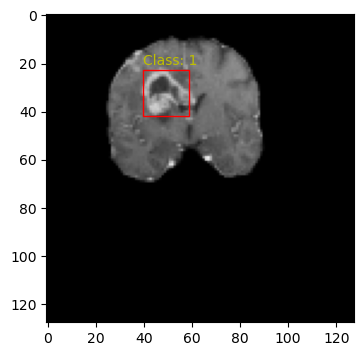

In [221]:
# A sample taget
show_image(X= X_test[0], labels=test_labels_df.iloc[0])

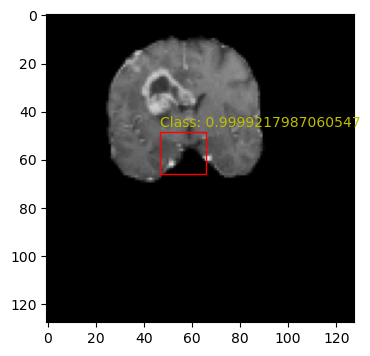

In [222]:
# The predicted taget
show_image(X= X_test[0], labels=y_pred_df.iloc[0])

In [223]:
# Calculate F1 score
f1 = f1_score(test_labels_df['class'], y_pred_classes2, average='micro')
print(f"F1 score: {f1}", '\n')

R2= r2_score(test_labels_df[['x_cent', 'y_cent', 'width', 'height']], y_pred_bbox)
print(f"R2 score: {R2}")

F1 score: 0.48863636363636365 

R2 score: -0.3324592977338757


In [224]:
# Calculate F1 score
Report = classification_report(test_labels_df['class'], y_pred_classes2)
print(Report)

              precision    recall  f1-score   support

           0       0.46      0.40      0.43        42
           1       0.51      0.57      0.54        46

    accuracy                           0.49        88
   macro avg       0.48      0.48      0.48        88
weighted avg       0.49      0.49      0.49        88



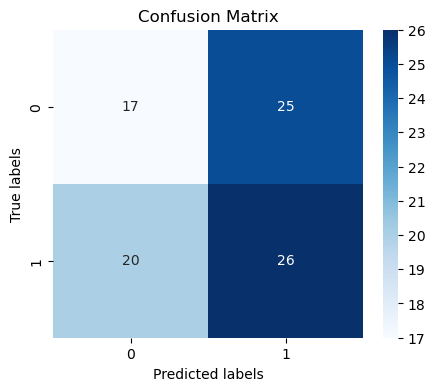

In [225]:
# Create confusion matrix
cm = confusion_matrix(test_labels_df['class'], y_pred_classes2)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
#plt.xticks(np.arange(1), labels, rotation=45)
#plt.yticks(np.arange(1), labels)
plt.show()

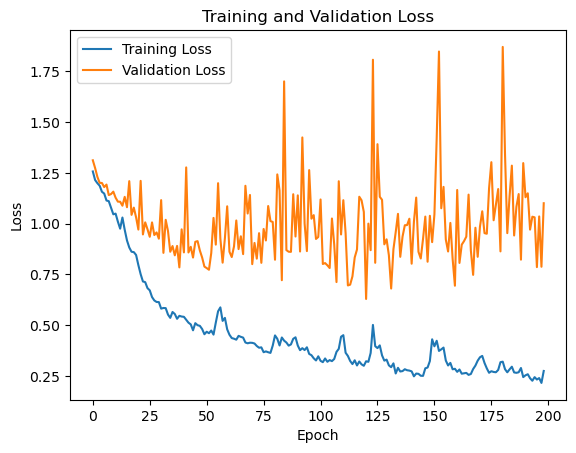

In [230]:
# Plot the loss values
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

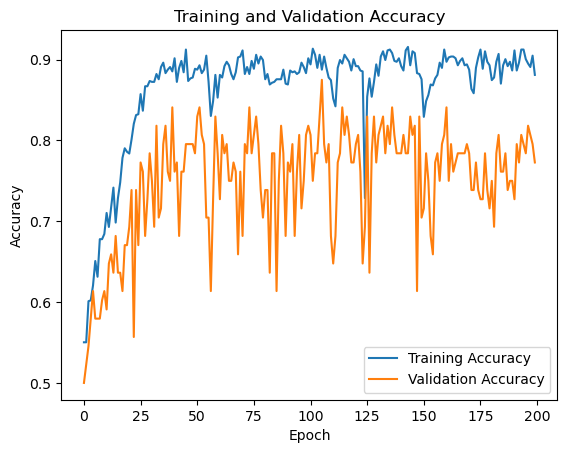

In [227]:
# Plot the accuracy values
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [228]:
# Define the directory and filename
save_dir = 'Saved Models'
model_name = 'Brain_Tumor_Detection-Arch-1-4.h5'

# Save the model
model.save(os.path.join(save_dir, model_name))

C:\ProgramData\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
